In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from lib.feature_extractor import extraction_model as em
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from externals.d2net.lib import localization, utils
from lib import autoencoder, attention_model
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv
from lib import correspondence_datamodule
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
import cv2

In [3]:
class DummyEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnet50(pretrained=True)
        self.extractor = correspondence_datamodule.ResnetActivationExtractor(self.model)
        self.encoded_channels=1024
    
    def forward(self, image):
        a = self.extractor(image)
        return {
            'early': a['layer3_conv3'],
            'middle': a['layer3_conv3'],
            'deep': a['layer3_conv3'],
        }

[tensor([[[[ 4.7608e-01,  4.2465e-01,  4.2965e-01,  ...,  4.3886e-01,
            4.6416e-01,  6.0790e-01],
          [-6.0557e-02, -1.3498e-01,  2.8979e-01,  ...,  8.9624e-02,
           -2.9196e-01, -3.4870e-01],
          [ 3.0233e-01,  3.0358e-01, -1.8941e+00,  ..., -7.8849e-01,
            2.2965e+00,  6.9951e-01],
          ...,
          [-4.6912e-02,  2.6895e+00, -1.2276e-01,  ...,  4.9538e-01,
           -1.6918e-02, -4.0230e-01],
          [ 2.9034e-01,  1.6927e+01,  1.6172e+00,  ..., -6.7637e-01,
           -2.7354e-01,  8.9221e-02],
          [-7.2345e-01, -5.4466e-01, -5.0027e-01,  ..., -4.7404e-01,
           -4.8133e-01, -6.7699e-01]]],


        [[[ 4.9631e-01,  4.2675e-01,  3.3105e-01,  ..., -3.3350e-01,
            1.6430e-02, -6.3455e-01],
          [ 4.5258e-01,  2.6233e-01,  6.2822e-01,  ..., -1.4857e-01,
            1.4379e-01, -4.8552e-01],
          [ 4.4986e-01, -3.4055e+00,  3.4472e-01,  ..., -8.3787e-01,
            3.7857e-01, -4.9284e-01],
          ...,
  

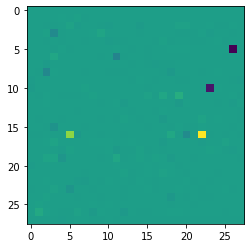

torch.Size([662])


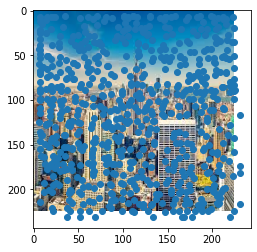

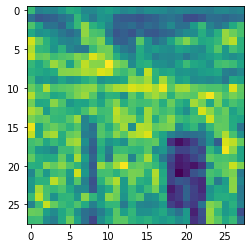

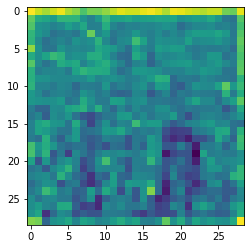

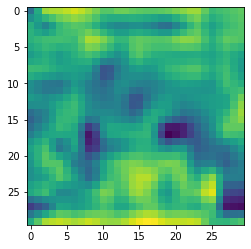

In [33]:
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/mark/eth/enc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3)
image = Image.open('/home/mark/Downloads/test.jpg')
image_np = np.array(image)
image = utils.preprocess_image(image_np)
image = torch.as_tensor(image)
image = torch.unsqueeze(image, 0)

keypoints, descriptors, scores, detections = extraction_model(image)

print(scores.size())

plt.imshow(image_np)
plt.scatter(keypoints[:, 0], keypoints[:, 1])
plt.show()
plt.imshow(detections[0])
plt.show()
plt.imshow(detections[1])
plt.show()
plt.imshow(detections[2])

In [22]:
pair_idx = 1
assert(pair_idx in [1, 2, 3])
pair_path = os.path.join('qualitative/images', f'pair_{pair_idx}')

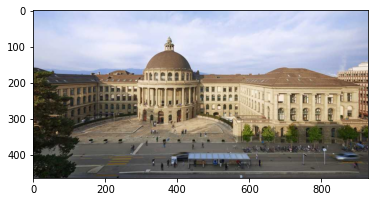

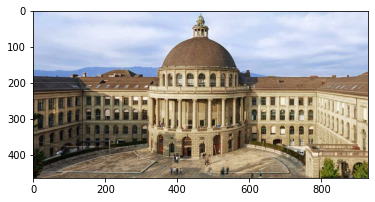

In [23]:
img = Image.open(os.path.join(pair_path, '1.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image1_np = np.array(img)
img = Image.open(os.path.join(pair_path, '2.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image2_np = np.array(img)
image1 = utils.preprocess_image(image1_np)
image1 = torch.as_tensor(image1)
image1 = torch.unsqueeze(image1, 0)
image2 = utils.preprocess_image(image2_np)
image2 = torch.as_tensor(image2)
image2 = torch.unsqueeze(image2, 0)

plt.imshow(image1_np)
plt.show()
plt.imshow(image2_np)
plt.show()

In [29]:
# encoder = DummyEncoder().eval()
# attention = attention_model.MultiAttentionLayer(encoder).eval()

# extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=4, thresh=0.0)
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/mark/eth/enc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3, thresh=0.2)

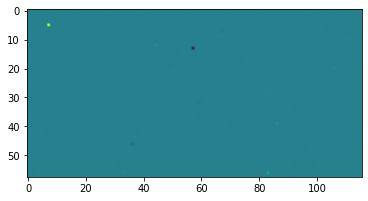

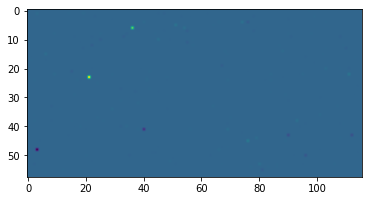

225 --> 225
206 --> 206
tensor([0.2662, 0.2650, 0.2507, 0.2499, 0.2497, 0.2468, 0.2467, 0.2460, 0.2452,
        0.2450, 0.2447, 0.2447, 0.2441, 0.2440, 0.2437, 0.2429, 0.2427, 0.2426,
        0.2417, 0.2415, 0.2415, 0.2413, 0.2408, 0.2404, 0.2399, 0.2397, 0.2393,
        0.2386, 0.2379, 0.2378, 0.2377, 0.2374, 0.2370, 0.2368, 0.2365, 0.2360,
        0.2360, 0.2358, 0.2356, 0.2355, 0.2354, 0.2353, 0.2343, 0.2340, 0.2329,
        0.2328, 0.2327, 0.2325, 0.2323, 0.2318, 0.2312, 0.2310, 0.2310, 0.2304,
        0.2301, 0.2299, 0.2294, 0.2290, 0.2274, 0.2257, 0.2256, 0.2246, 0.2239,
        0.2238, 0.2232, 0.2229, 0.2229, 0.2226, 0.2222, 0.2220, 0.2215, 0.2213,
        0.2212, 0.2204, 0.2203, 0.2202, 0.2201, 0.2191, 0.2189, 0.2179, 0.2175,
        0.2160, 0.2157, 0.2149, 0.2148, 0.2146, 0.2141, 0.2140, 0.2140, 0.2134,
        0.2128, 0.2125, 0.2122, 0.2121, 0.2120, 0.2116, 0.2114, 0.2113, 0.2110,
        0.2109, 0.2106, 0.2100, 0.2100, 0.2097, 0.2093, 0.2093, 0.2089, 0.2087,
        0.2086, 

In [30]:
kp1, descr1, scores1, det1 = extraction_model(image1)
kp2, descr2, scores2, det2 = extraction_model(image2)

# For dummy encoder, we get 3 times the same output
s1 = scores1.size()[0] #// 3
print(f'{scores1.size()[0]} --> {s1}')
kp1 = kp1[:s1, :].numpy()
descr1 = descr1[:s1, :].numpy()
scores1 = scores1[:s1]

s2 = scores2.size()[0] #// 3
print(f'{scores2.size()[0]} --> {s2}')
kp2 = kp2[:s2, :].numpy()
descr2 = descr2[:s2, :].numpy()
scores2 = scores2[:s2]

print(scores1)
print(scores2)

In [31]:
matches = match_descriptors(descr1, descr2, cross_check=True)
n_matches = len(matches)
print(len(matches))

1


In [32]:
keypoints_left = kp1[matches[:, 0], : 2]
keypoints_right = kp2[matches[:, 1], : 2]
print(keypoints_left)
np.random.seed(0)
model, inliers = ransac(
    (keypoints_left, keypoints_right),
    ProjectiveTransform, min_samples=4,
    residual_threshold=4, max_trials=10000
)
n_inliers = np.sum(inliers)
print('Number of inliers: %d.' % n_inliers)

[[7.470068 7.302349]]


ValueError: `min_samples` must be in range (0, <number-of-samples>)

In [ ]:
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image3)
plt.axis('off')
plt.show()

inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_matches)]
image4 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image4)
plt.axis('off')
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det1[0])
axs[1].imshow(det1[1])
axs[2].imshow(det1[2])
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det2[0])
axs[1].imshow(det2[1])
axs[2].imshow(det2[2])
plt.show()
print(det2[:])